# Mode d'emploi sur l'utilisation de la librairie

#### Import des sous modules de la librairie

In [1]:
from tools import RateCurveType, InterpolationType, CalendarConvention
from kernel.market_data.market import Market
from kernel.products.options.vanilla_options import EuropeanCallOption
from kernel.models.pricing_engines.mc_pricing_engine import MCPricingEngine
import numpy as np
from scipy.stats import norm

#### Informations renseignées par l'utilisateur (sur l'interface)

In [2]:
security = "Apple"
rate_curve_type = RateCurveType.RF_US_TREASURY
interpolation_type = InterpolationType.SVENSSON
# volatility_surface_type = VolatilitySurfaceType.SVI
calendar = CalendarConvention.ACT_360

#### Initialisation du marché

In [3]:
market = Market(underlying_name=security,
                rate_curve_type=RateCurveType.RF_US_TREASURY,
                interpolation_type=InterpolationType.SVENSSON,
                # volatility_surface_type=VolatilitySurfaceType.SVI,
                calendar_convention=CalendarConvention.ACT_360)

#### Initialisation du pricer et du produit à pricer

In [7]:
call_option = EuropeanCallOption(maturity=2, strike=market.underlying_asset.last_price)
engine = MCPricingEngine(market=market, n_paths=1000000)

#### Pricing

In [8]:
price = engine.compute_price(call_option)
print(price)

20.213241273708583


#### Calcul des grecques

In [9]:
greeks = engine.compute_greeks(call_option)
print(greeks)

{'Delta': np.float64(0.6192700580243127), 'Gamma': np.float64(0.008185452315956354), 'Vega': np.float64(0.0), 'Theta': np.float64(-1.090924462303633), 'Rho': np.float64(0.0)}


#### Comparaison avec la formule fermée

In [10]:
def black_scholes(S, K, T, sigma, option_type="call"):
    """
    Calcule le prix d'une option européenne avec le modèle Black-Scholes.

    :param S: Prix actuel du sous-jacent
    :param K: Strike (prix d'exercice)
    :param T: Temps jusqu'à l'expiration en années
    :param sigma: Volatilité implicite
    :param option_type: "call" ou "put"
    :return: Prix de l'option
    """
    r = market.get_rate(T) / 100
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == "call":
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:  # Put
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

    return price

In [11]:
closed_form_price = black_scholes(S=market.underlying_asset.last_price, K=call_option.strike, 
                                  T=call_option.maturity, sigma=market.get_volatility(call_option.strike, call_option.maturity*252))
print(closed_form_price)

20.233291525891424


## --------------------------------------------------------------------------------------------------

#### Exemples d'utilisation des informations stockées dans le marché

In [23]:
print(f"Taux 1.2Y interpolé: {round(market.get_rate(1.2),2)}%")
print(f"Volatilité K=220, T=24 jours interpolée: {round(market.get_volatility(220, 24),2)}%")

Taux 1.2Y interpolé: 1.91%
Volatilité K=220, T=24 jours interpolée: 0.37%


#### Visualisation de l'interpolation de la courbe de taux

c:\Users\thibc\OneDrive\Documents\Dev\Structured-Product-Pricing-Python\kernel\market_data\rate_curve\interpolators\svensson_interpolator.py:46: RuntimeWarning: invalid value encountered in scalar divide
  term1 = beta1 * (1 - np.exp(-t / tau1)) / (t / tau1)
c:\Users\thibc\OneDrive\Documents\Dev\Structured-Product-Pricing-Python\kernel\market_data\rate_curve\interpolators\svensson_interpolator.py:47: RuntimeWarning: invalid value encountered in scalar divide
  term2 = beta2 * ((1 - np.exp(-t / tau1)) / (t / tau1) - np.exp(-t / tau1))
c:\Users\thibc\OneDrive\Documents\Dev\Structured-Product-Pricing-Python\kernel\market_data\rate_curve\interpolators\svensson_interpolator.py:48: RuntimeWarning: invalid value encountered in scalar divide
  term3 = beta3 * ((1 - np.exp(-t / tau2)) / (t / tau2) - np.exp(-t / tau2))


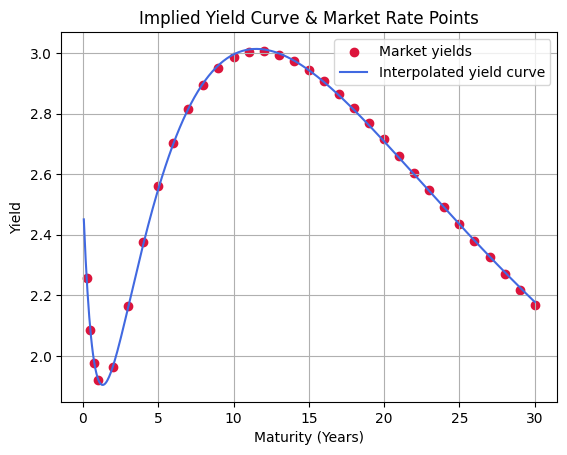

In [24]:
market.rate_curve.display_curve()

#### Visualisation de la surface de volatilité

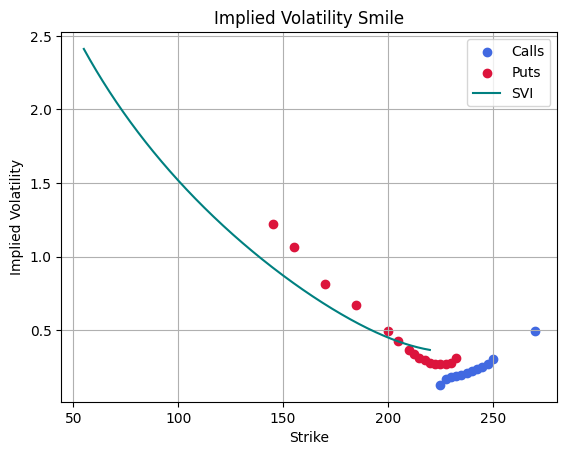

In [25]:
market.volatility_surface.display_smile(24)

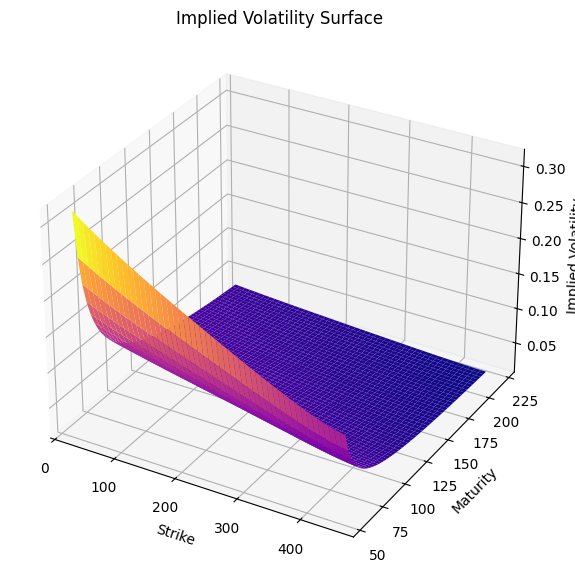

In [26]:
market.volatility_surface.display_surface()